In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score,precision_score,precision_recall_curve,roc_curve,roc_auc_score,recall_score,matthews_corrcoef,fbeta_score
from imblearn.metrics import geometric_mean_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load your dataset (replace 'your_dataset.csv' with your dataset file)
df = pd.read_csv(r"D:\Bos\WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dataset shape:", df.shape)
print(df.head())

# Convert TotalCharges to numeric if exists
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(inplace=True)

# Target column conversion (assuming 'Churn')
if 'Churn' in df.columns:
    df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
else:
    raise ValueError("No 'Churn' column found in the dataset.")

# One-hot encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']



Dataset shape: (7043, 19)
   gender Partner Dependents  tenure PhoneService     MultipleLines  \
0  Female     Yes         No       1           No  No phone service   
1    Male      No         No      34          Yes                No   
2    Male      No         No       2          Yes                No   
3    Male      No         No      45           No  No phone service   
4  Female      No         No       2          Yes                No   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          N

--- Original Baseline: Training Set Size ---
1. Total Training Samples: 3445
   - Minority (Churners): 915
   - Majority (Non-Churners): 2530
   - Imbalance Ratio: 26.56%
-------------------------------------------

===== Random Forest =====
Best Threshold: 0.75
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1549
           1       0.79      0.16      0.26       561

    accuracy                           0.76      2110
   macro avg       0.78      0.57      0.56      2110
weighted avg       0.77      0.76      0.70      2110



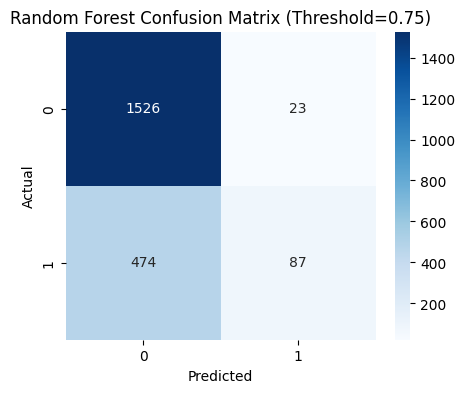

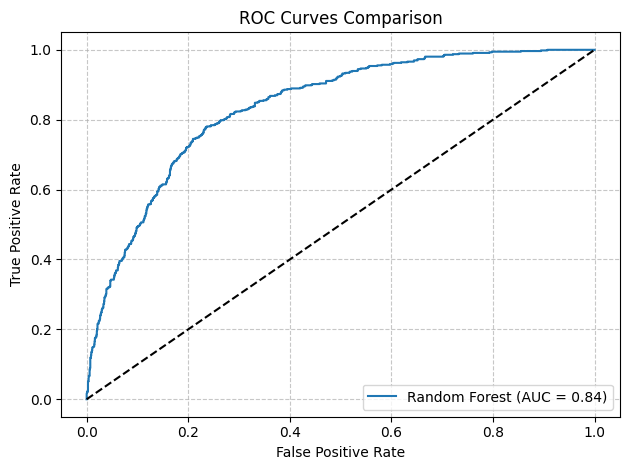


===== Logistic Regression =====
Best Threshold: 0.71
              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1549
           1       0.72      0.13      0.22       561

    accuracy                           0.76      2110
   macro avg       0.74      0.56      0.54      2110
weighted avg       0.75      0.76      0.69      2110



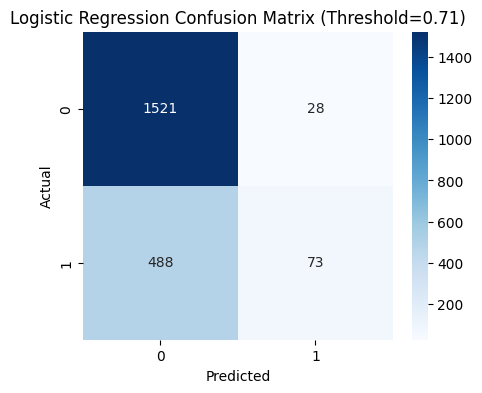

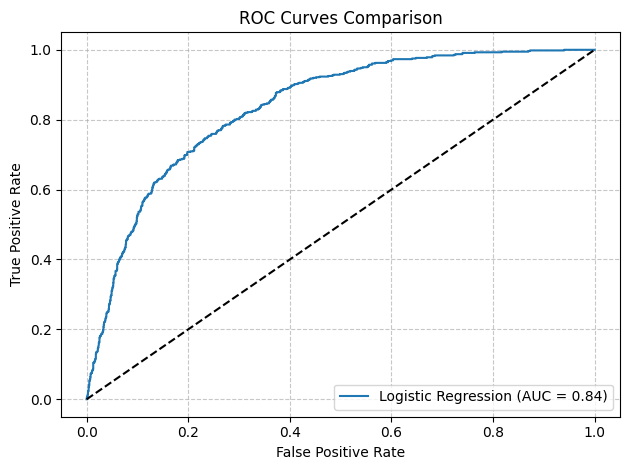


===== Decision Tree =====
Best Threshold: 0.72
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1549
           1       0.61      0.36      0.45       561

    accuracy                           0.77      2110
   macro avg       0.70      0.64      0.65      2110
weighted avg       0.75      0.77      0.75      2110



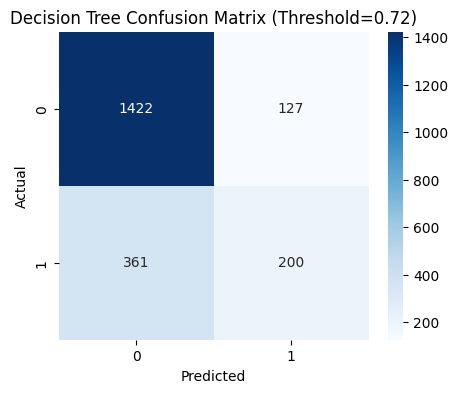

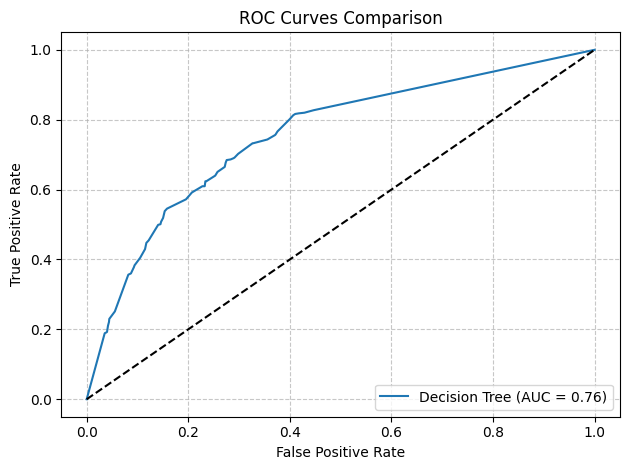


===== XGBoost =====
Best Threshold: 0.75
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1549
           1       0.79      0.23      0.35       561

    accuracy                           0.78      2110
   macro avg       0.79      0.60      0.61      2110
weighted avg       0.78      0.78      0.73      2110



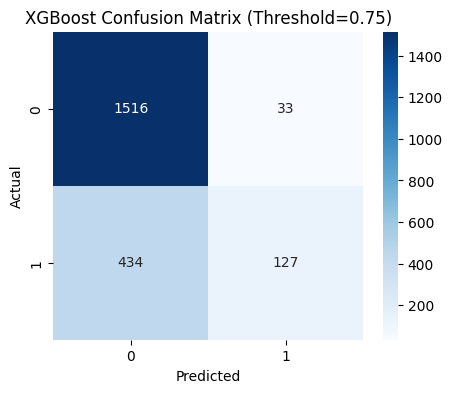

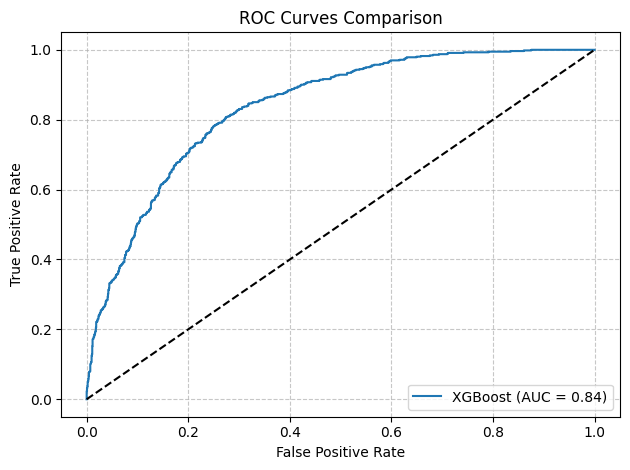


===== LightGBM =====
Best Threshold: 0.77
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1549
           1       0.78      0.21      0.33       561

    accuracy                           0.77      2110
   macro avg       0.78      0.59      0.60      2110
weighted avg       0.78      0.77      0.72      2110



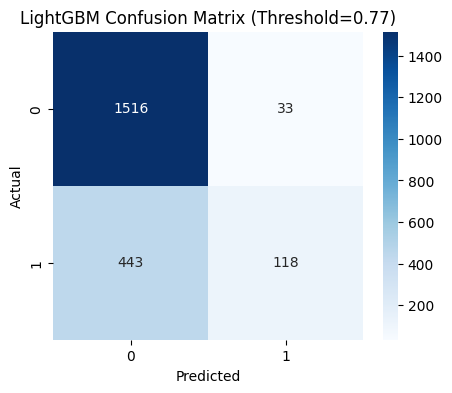

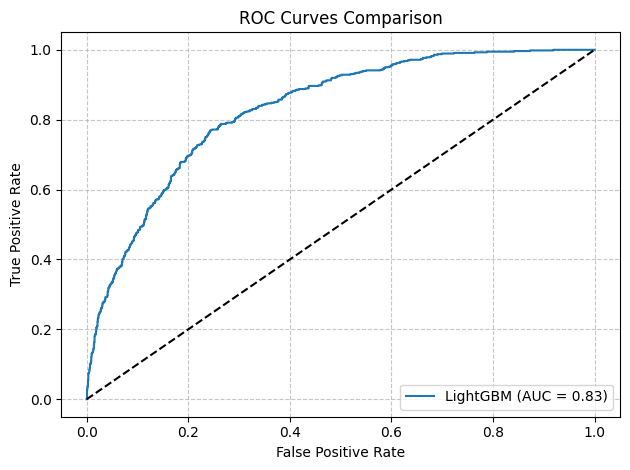


===== CatBoost =====
Best Threshold: 0.75
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1549
           1       0.75      0.21      0.33       561

    accuracy                           0.77      2110
   macro avg       0.76      0.59      0.60      2110
weighted avg       0.77      0.77      0.72      2110



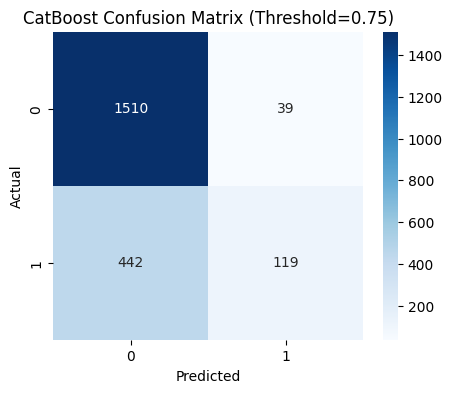

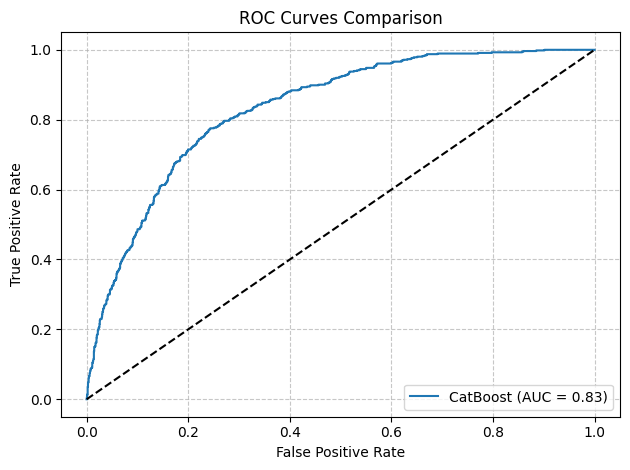


===== Model Comparison Summary =====
                 Model  Best Threshold  Accuracy  F1 Score       AUC  \
0        Random Forest            0.75  0.764455  0.259314  0.837157   
1  Logistic Regression            0.71  0.755450  0.220544  0.836147   
2        Decision Tree            0.72  0.768720  0.450450  0.755787   
3              XGBoost            0.75  0.778673  0.352288  0.837818   
4             LightGBM            0.77  0.774408  0.331461  0.830872   
5             CatBoost            0.75  0.772038  0.331015  0.833339   

   Precision(churn=0)  Precision(churn=1)  Recall(churn=1)  Matthews Corr  \
0            0.763000            0.790909         0.155080       0.278704   
1            0.757093            0.722772         0.130125       0.231880   
2            0.797532            0.611621         0.356506       0.335141   
3            0.777436            0.793750         0.226381       0.342253   
4            0.773864            0.781457         0.210339       0.32399

In [3]:
import warnings
warnings.filterwarnings("ignore")

# ==============================
# 1. FIX: Split FIRST, then Scale
# ==============================
# Split into Train+Val and Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split Train+Val into separate Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

# Scale ONLY using training statistics to prevent leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("--- Original Baseline: Training Set Size ---")

# Calculate counts
total_samples = len(X_train)
churn_count = sum(y_train == 1)
no_churn_count = sum(y_train == 0)
imbalance_ratio = (churn_count / total_samples) * 100

print(f"1. Total Training Samples: {total_samples}")
print(f"   - Minority (Churners): {churn_count}")
print(f"   - Majority (Non-Churners): {no_churn_count}")
print(f"   - Imbalance Ratio: {imbalance_ratio:.2f}%")
print("-------------------------------------------")
# ==============================
# 2. FIX: Wider Threshold Range
# ==============================
def tune_threshold(model, X_val, y_val, thresholds=np.arange(0.4, 0.9,0.01)):
    y_val_probs = model.predict_proba(X_val)[:,1]
    best_threshold = 0.5
    best_f1 = 0
    for t in thresholds:
        y_val_pred = (y_val_probs >= t).astype(int)
        f1 = fbeta_score(y_val, y_val_pred,beta=0.2)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    return best_threshold

# [plot_confusion function remains exactly as you had it]
def plot_confusion(y_true, y_pred, model_name, threshold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix (Threshold={threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 5. EXECUTE ALL 6 MODELS
models = {
    # 1. Random Forest: Reduced depth to prevents overfitting to synthetic noise
    # removed class_weight because data is already 50/50 balanced
    "Random Forest": RandomForestClassifier(
        n_estimators=500,           # 1000 is often overkill
        max_depth=15,               # 40 is way too deep; 15 keeps it generalizing
        min_samples_split=10,       # Higher number prevents isolating single synthetic rows
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        n_jobs=-1,
        criterion='gini'
    ),

    # 2. Logistic Regression: 
    # removed class_weight='balanced'
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight=None,          # VITAL: Data is already balanced!
        random_state=42
    ),

    # 3. Decision Tree:
    # Reduced depth significantly
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,               # 40 causes massive overfitting
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        criterion='gini'
    ),

    # 4. XGBoost:
    # scale_pos_weight=1 means "treat classes equally"
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=6,                # 12 is too deep for tabular data (usually 4-8 is best)
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,                    # Higher gamma = more conservative (higher precision)
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_weight=3,
        scale_pos_weight=1,         # VITAL: Removed the 1.05 bias
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        tree_method='hist'
    ),

    # 5. LightGBM:
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        max_depth=8,                # Restrained depth
        learning_rate=0.02,
        num_leaves=32,              # 70 was likely overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_samples=10,
        random_state=42,
        class_weight=None,          # VITAL: Removed bias
        verbose=-1,
        n_jobs=-1,
        boosting_type='gbdt'
    ),

    # 6. CatBoost:
    # auto_class_weights='None' because we fixed the data ourselves
    "CatBoost": CatBoostClassifier(
        iterations=800,
        depth=6,                    # 12 is extremely deep for CatBoost (slow & overfits)
        learning_rate=0.02,
        l2_leaf_reg=5,              # Higher regularization = higher precision
        random_strength=1,
        bagging_temperature=0.5,
        border_count=128,
        random_state=42,
        verbose=0,
        thread_count=-1,
        auto_class_weights='None'   # VITAL: Do not let model re-balance
    )
}

# ==============================
# Train, tune threshold & evaluate
# ==============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    best_threshold = tune_threshold(model, X_val, y_val)
    
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc_val = roc_auc_score(y_test, y_probs)
    
    print(f"\n===== {name} =====")
    print(f"Best Threshold: {best_threshold:.2f}")
    print(classification_report(y_test, y_pred))
    
    plot_confusion(y_test, y_pred, name, best_threshold)

    # ROC Plotting logic
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_val:.2f})")
    
    results.append({
        "Model": name,
        "Best Threshold": best_threshold,
        "Accuracy": acc,
        "F1 Score": f1,
        "AUC": roc_auc_val,
        "Precision(churn=0)": precision_score(y_test, y_pred, pos_label=0),
        "Precision(churn=1)": precision_score(y_test, y_pred, pos_label=1),
        "Recall(churn=1)": recall_score(y_test, y_pred, pos_label=1),
        "Matthews Corr": matthews_corrcoef(y_test, y_pred),
        "G-Mean": geometric_mean_score(y_test, y_pred)
    })
    # Finalize ROC Plot outside the loop to show all models together
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

original = pd.DataFrame(results)
print("\n===== Model Comparison Summary =====")
print(original)

--- SMOTE Only: Training Set Size Evolution ---
1. Original Encoded Training Size: 3445 samples
   - Minority (Churners): 915
   - Majority (Non-Churners): 2530

2. Final SMOTE-Balanced Training Size: 4301 samples
   - SMOTE-Generated Churners: 1771
   - SMOTE-Generated Non-Churners: 2530
   - Ratio (Minority/Majority): 0.70
----------------------------------------------

===== Random Forest =====
Best Threshold: 0.84
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1549
           1       0.76      0.12      0.21       561

    accuracy                           0.76      2110
   macro avg       0.76      0.55      0.53      2110
weighted avg       0.76      0.76      0.68      2110



<Figure size 1000x800 with 0 Axes>

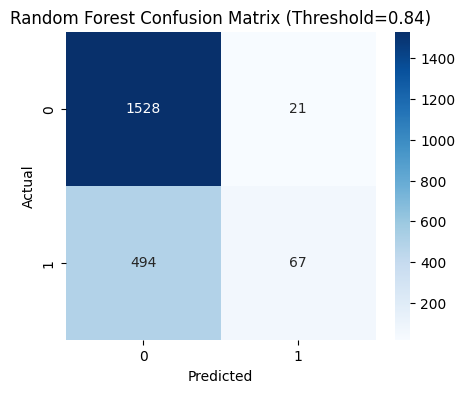

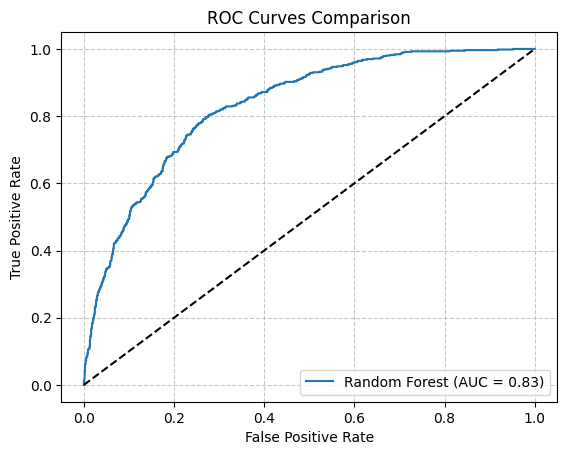


===== Logistic Regression =====
Best Threshold: 0.79
              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1549
           1       0.70      0.13      0.22       561

    accuracy                           0.75      2110
   macro avg       0.73      0.56      0.54      2110
weighted avg       0.74      0.75      0.69      2110



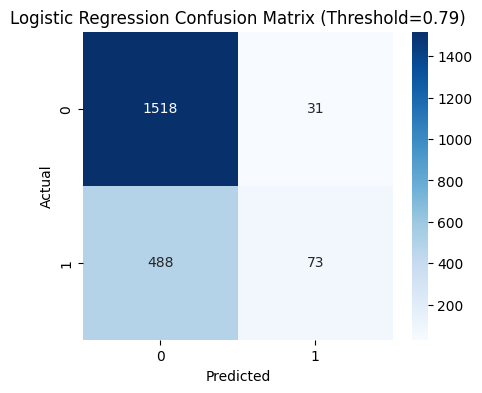

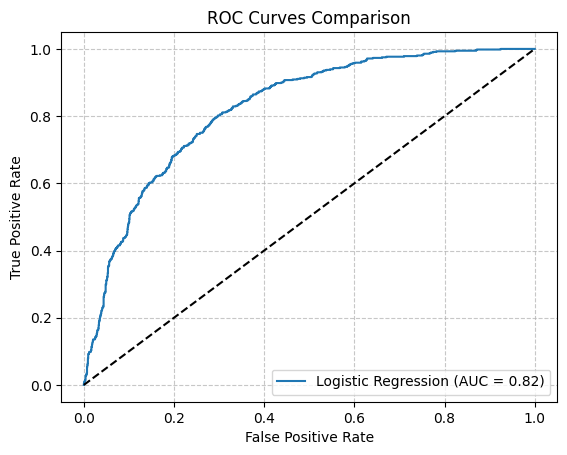


===== Decision Tree =====
Best Threshold: 0.80
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1549
           1       0.64      0.32      0.42       561

    accuracy                           0.77      2110
   macro avg       0.71      0.63      0.64      2110
weighted avg       0.75      0.77      0.74      2110



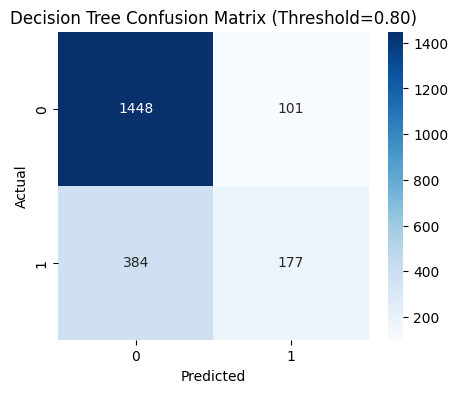

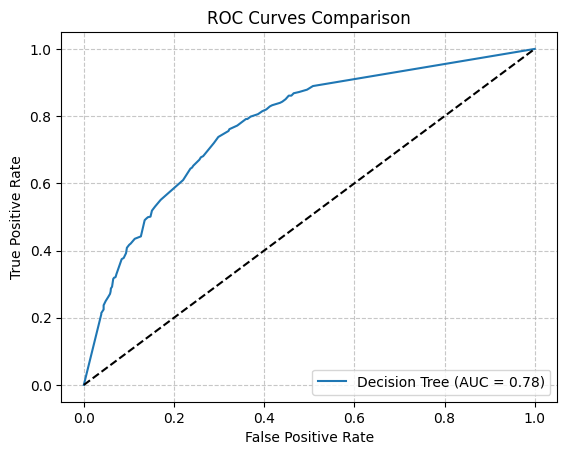


===== XGBoost =====
Best Threshold: 0.85
              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1549
           1       0.78      0.16      0.26       561

    accuracy                           0.76      2110
   macro avg       0.77      0.57      0.56      2110
weighted avg       0.77      0.76      0.70      2110



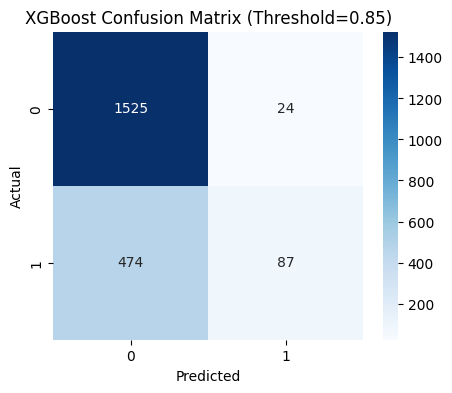

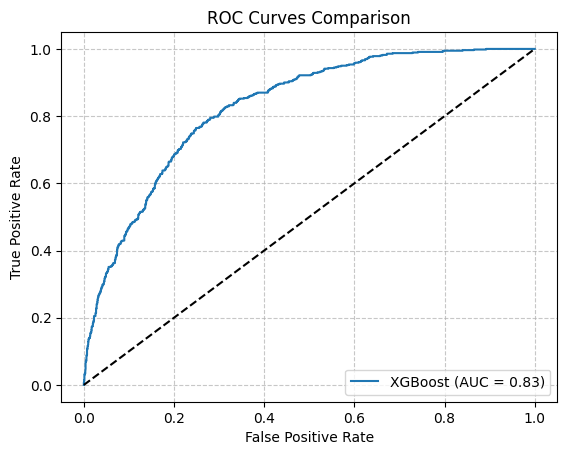


===== LightGBM =====
Best Threshold: 0.88
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1549
           1       0.83      0.13      0.23       561

    accuracy                           0.76      2110
   macro avg       0.80      0.56      0.55      2110
weighted avg       0.78      0.76      0.69      2110



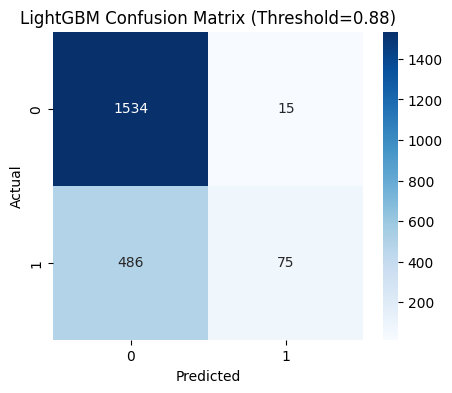

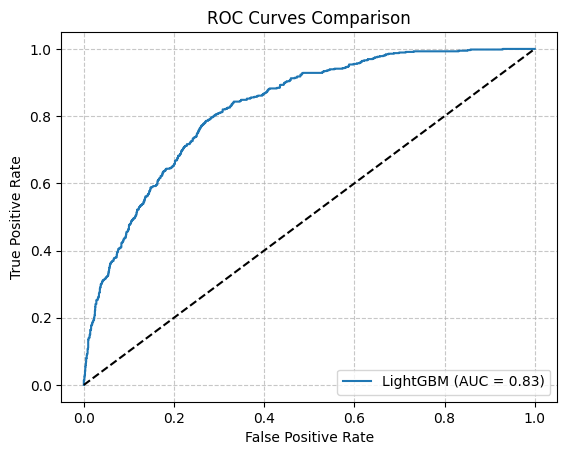


===== CatBoost =====
Best Threshold: 0.89
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1549
           1       0.81      0.09      0.16       561

    accuracy                           0.75      2110
   macro avg       0.78      0.54      0.51      2110
weighted avg       0.77      0.75      0.67      2110



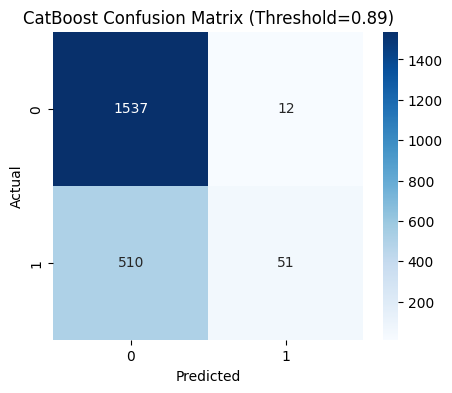

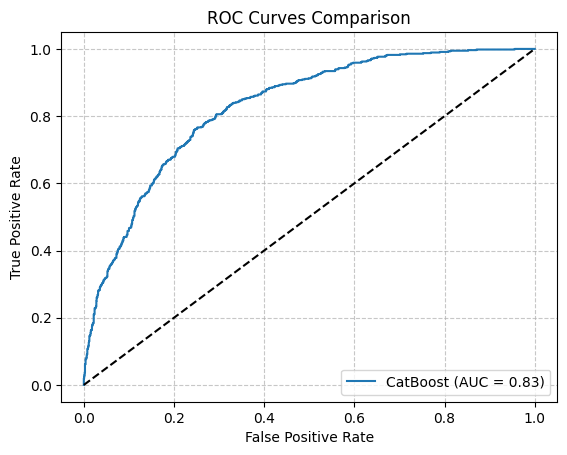


===== Model Comparison Summary =====
                 Model  Best Threshold  Accuracy  F1 Score       AUC  \
0        Random Forest            0.84  0.755924  0.206471  0.832283   
1  Logistic Regression            0.79  0.754028  0.219549  0.824242   
2        Decision Tree            0.80  0.770142  0.421931  0.775397   
3              XGBoost            0.85  0.763981  0.258929  0.827899   
4             LightGBM            0.88  0.762559  0.230415  0.826670   
5             CatBoost            0.89  0.752607  0.163462  0.827417   

   Precision(churn=0)  Precision(churn=1)  Recall(churn=1)  MaThthews Corr  \
0            0.755687            0.761364         0.119430        0.233969   
1            0.756730            0.701923         0.130125        0.224729   
2            0.790393            0.636691         0.315508        0.326957   
3            0.762881            0.783784         0.155080        0.276237   
4            0.759406            0.833333         0.133690        0

In [17]:
import warnings
warnings.filterwarnings("ignore")

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# ==============================
# 1. Split (RAW data first)
# ==============================
# Split raw X and y
X_train_full, X_test_raw, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train_raw, X_val_raw, y_train_orig, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)
combined = pd.concat([X_train_raw, X_val_raw, X_test_raw], axis=0)
combined_encoded = pd.get_dummies(combined, drop_first=True)
X_train_enc = combined_encoded.iloc[:len(X_train_raw)]
X_val_enc = combined_encoded.iloc[len(X_train_raw):len(X_train_raw)+len(X_val_raw)]
X_test_enc = combined_encoded.iloc[len(X_train_raw)+len(X_val_raw):]

print("--- SMOTE Only: Training Set Size Evolution ---")

# Step 0: Pre-SMOTE Size
print(f"1. Original Encoded Training Size: {len(X_train_enc)} samples")
print(f"   - Minority (Churners): {sum(y_train_orig == 1)}")
print(f"   - Majority (Non-Churners): {sum(y_train_orig == 0)}")

# ==============================
# 2. APPLY SMOTE ON RAW DATA
# ==============================
# Resample the raw training data first
# Note: Ensure categorical features are handled or encoded before this step if necessary
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_resampled_raw, y_train = smote.fit_resample(X_train_enc, y_train_orig)

# Step 1: Post-SMOTE Size
print(f"\n2. Final SMOTE-Balanced Training Size: {len(X_train_resampled_raw)} samples")
print(f"   - SMOTE-Generated Churners: {sum(y_train == 1)}")
print(f"   - SMOTE-Generated Non-Churners: {sum(y_train == 0)}")
print(f"   - Ratio (Minority/Majority): {sum(y_train == 1) / sum(y_train == 0):.2f}")
print("----------------------------------------------")
# ==============================
# 3. SCALE AFTER SMOTE SAMPLES GENERATED
# ==============================
scaler = StandardScaler()

# Fit and transform the balanced training data
X_train_scaled = scaler.fit_transform(X_train_resampled_raw)

# Use the fitted scaler to transform Validation and Test sets
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Restore Headers for interpretability
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)


# ==============================
# 4. Threshold Tuning and Plotting Functions
# ==============================
def tune_threshold(model, X_val, y_val, thresholds=np.arange(0.4, 0.9, 0.01)):
    y_val_probs = model.predict_proba(X_val)[:,1]
    best_threshold, best_f1 = 0.5, 0
    for t in thresholds:
        y_val_pred = (y_val_probs >= t).astype(int)
        f1 = fbeta_score(y_val, y_val_pred, beta=0.2)
        if f1 > best_f1:
            best_f1, best_threshold = f1, t
    return best_threshold

def plot_confusion(y_true, y_pred, model_name, threshold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix (Threshold={threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ==============================
# 5. EXECUTE ALL 6 MODELS
# ==============================
# (Models dictionary remains the same as your provided code)

results = []
# Prepare ROC plot
plt.figure(figsize=(10, 8))
# 5. EXECUTE ALL 6 MODELS
model = {
    # 1. Random Forest: Reduced depth to prevents overfitting to synthetic noise
    # removed class_weight because data is already 50/50 balanced
    "Random Forest": RandomForestClassifier(
        n_estimators=500,           # 1000 is often overkill
        max_depth=15,               # 40 is way too deep; 15 keeps it generalizing
        min_samples_split=10,       # Higher number prevents isolating single synthetic rows
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        n_jobs=-1,
        criterion='gini'
    ),

    # 2. Logistic Regression: 
    # removed class_weight='balanced'
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight=None,          # VITAL: Data is already balanced!
        random_state=42
    ),

    # 3. Decision Tree:
    # Reduced depth significantly
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,               # 40 causes massive overfitting
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        criterion='gini'
    ),

    # 4. XGBoost:
    # scale_pos_weight=1 means "treat classes equally"
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=6,                # 12 is too deep for tabular data (usually 4-8 is best)
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,                    # Higher gamma = more conservative (higher precision)
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_weight=3,
        scale_pos_weight=1,         # VITAL: Removed the 1.05 bias
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        tree_method='hist'
    ),

    # 5. LightGBM:
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        max_depth=8,                # Restrained depth
        learning_rate=0.02,
        num_leaves=32,              # 70 was likely overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_samples=10,
        random_state=42,
        class_weight=None,          # VITAL: Removed bias
        verbose=-1,
        n_jobs=-1,
        boosting_type='gbdt'
    ),

    # 6. CatBoost:
    # auto_class_weights='None' because we fixed the data ourselves
    "CatBoost": CatBoostClassifier(
        iterations=800,
        depth=6,                    # 12 is extremely deep for CatBoost (slow & overfits)
        learning_rate=0.02,
        l2_leaf_reg=5,              # Higher regularization = higher precision
        random_strength=1,
        bagging_temperature=0.5,
        border_count=128,
        random_state=42,
        verbose=0,
        thread_count=-1,
        auto_class_weights='None'   # VITAL: Do not let model re-balance
    )
}

for name, model in model.items():
    # Fit on balanced, scaled training data
    model.fit(X_train, y_train)
    
    # Tune threshold on scaled, imbalanced validation data
    best_threshold = tune_threshold(model, X_val, y_val)
    
    # Evaluate on scaled, imbalanced test data
    y_probs = model.predict_proba(X_test)[:,1]
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)
    
    print(f"\n===== {name} =====")
    print(f"Best Threshold: {best_threshold:.2f}")
    print(classification_report(y_test,y_pred))
    
    plot_confusion(y_test, y_pred, name, best_threshold)

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    
    results.append({
        "Model": name, "Best Threshold": round(best_threshold, 2),
        "Accuracy": acc, "F1 Score": f1, "AUC": auc,
        "Precision(churn=0)":precision_score(y_test,y_pred,pos_label=0),
        "Precision(churn=1)": precision_score(y_test, y_pred, pos_label=1),
        "Recall(churn=1)": recall_score(y_test, y_pred, pos_label=1),
        "MaThthews Corr": matthews_corrcoef(y_test, y_pred),
        "G-Mean": geometric_mean_score(y_test, y_pred),
    })
    # Finalize ROC Plot
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



print("\n===== Model Comparison Summary =====")
smote_results = pd.DataFrame(results)
print(smote_results)

--- GAN Only: Training Set Size Evolution ---
1. Original Training Size: 3445 samples
   - Minority (Churners): 915
   - Majority (Non-Churners): 2530
Starting CTGAN Balancing Process...


Gen. (0.29) | Discrim. (-0.78): 100%|██████████| 500/500 [05:36<00:00,  1.49it/s] 


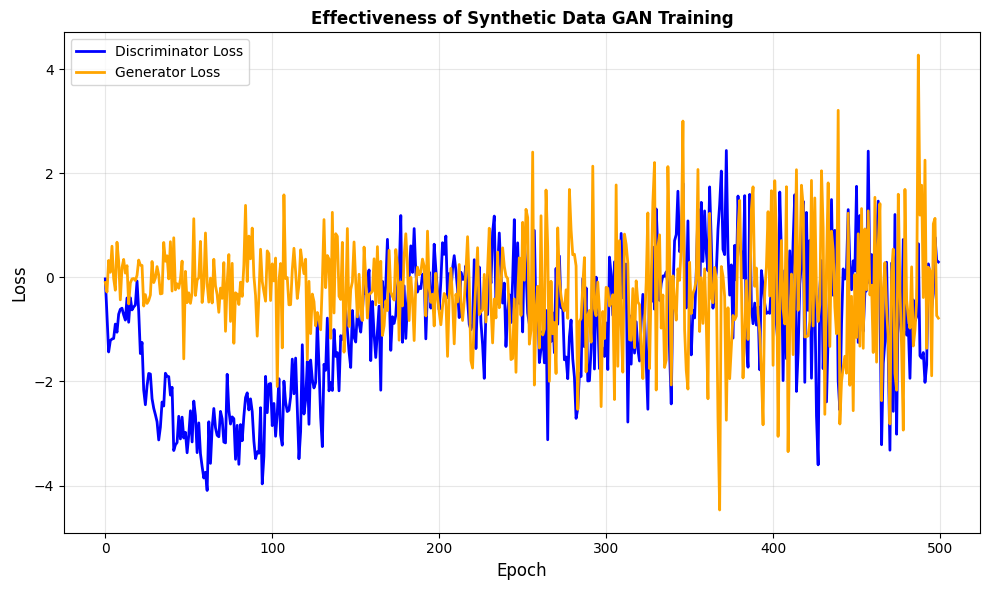

Generating 350 samples to reach an imbalance ratio of 50.0%

3. Final GAN-Only Training Size (Unbalanced): 3795 samples
   - Total Churners (Minority): 1265
   - Total Non-Churners (Majority): 2530
   - Final Minority Percentage: 33.33%
--------------------------------------------

--- Model Performance Results ---

--- Random Forest (Threshold: 0.7500) ---
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1549
           1       0.82      0.15      0.26       561

    accuracy                           0.77      2110
   macro avg       0.79      0.57      0.56      2110
weighted avg       0.78      0.77      0.70      2110



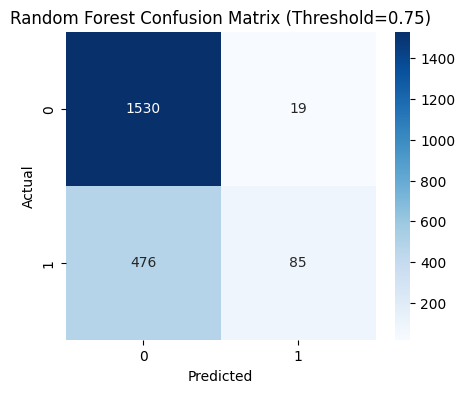

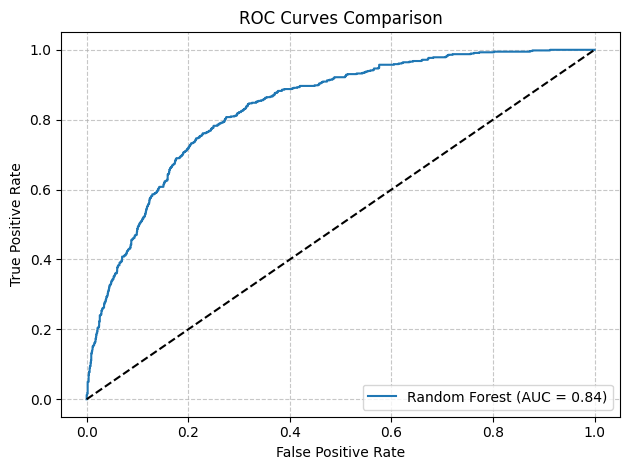


--- Logistic Regression (Threshold: 0.7200) ---
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1549
           1       0.71      0.12      0.20       561

    accuracy                           0.75      2110
   macro avg       0.73      0.55      0.53      2110
weighted avg       0.74      0.75      0.68      2110



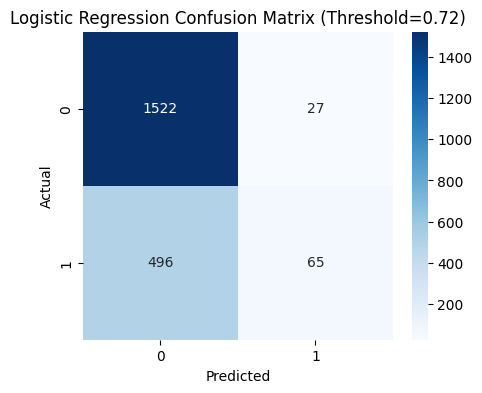

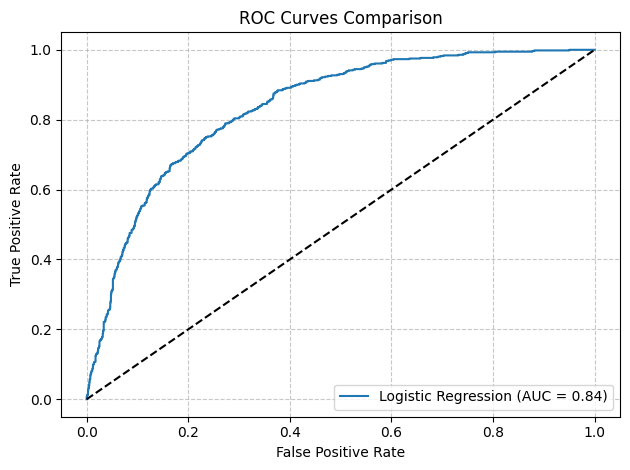


--- Decision Tree (Threshold: 0.7900) ---
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1549
           1       0.65      0.29      0.40       561

    accuracy                           0.77      2110
   macro avg       0.72      0.62      0.63      2110
weighted avg       0.75      0.77      0.74      2110



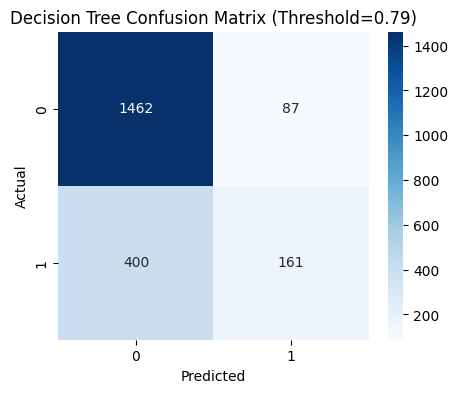

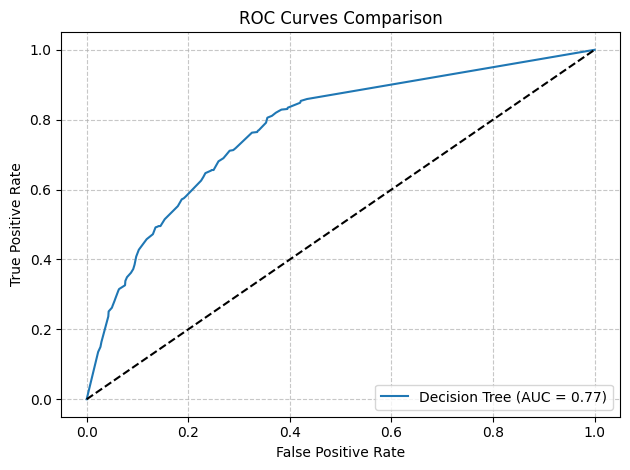


--- XGBoost (Threshold: 0.7500) ---
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1549
           1       0.78      0.22      0.34       561

    accuracy                           0.78      2110
   macro avg       0.78      0.60      0.61      2110
weighted avg       0.78      0.78      0.73      2110



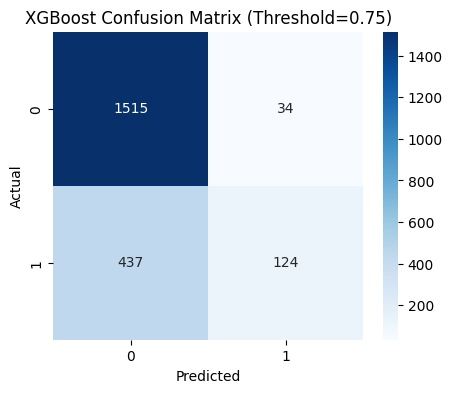

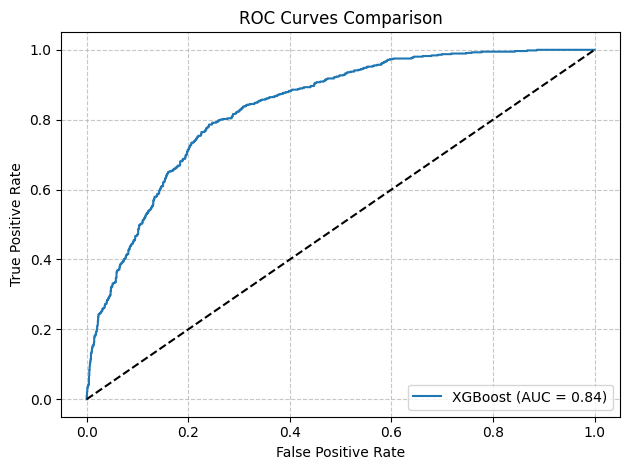


--- LightGBM (Threshold: 0.7100) ---
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1549
           1       0.74      0.27      0.39       561

    accuracy                           0.78      2110
   macro avg       0.76      0.62      0.63      2110
weighted avg       0.77      0.78      0.74      2110



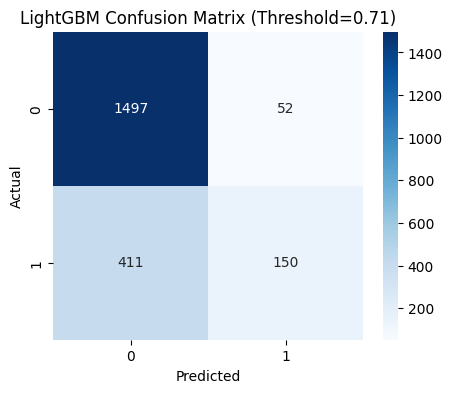

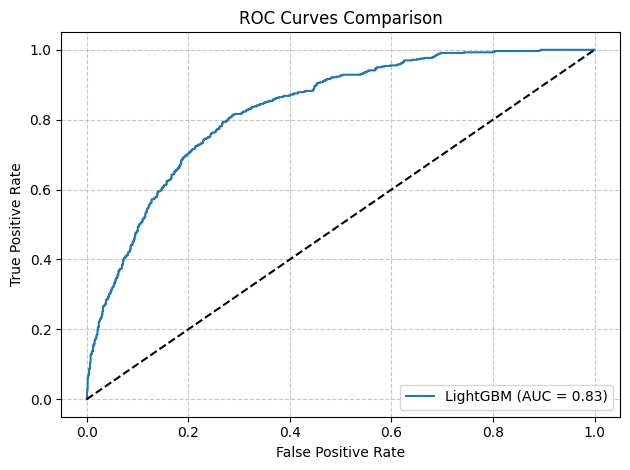


--- CatBoost (Threshold: 0.7400) ---
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1549
           1       0.75      0.24      0.36       561

    accuracy                           0.78      2110
   macro avg       0.77      0.61      0.61      2110
weighted avg       0.77      0.78      0.73      2110



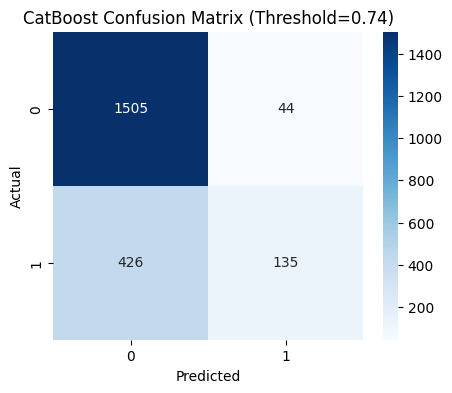

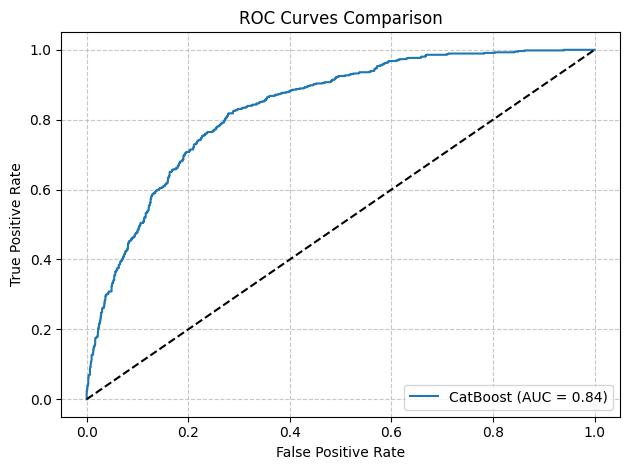


--- Summary of All Model Results ---
                 Model  Best Threshold  Accuracy  F1 Score       AUC  \
0        Random Forest            0.75  0.765403  0.255639  0.835821   
1  Logistic Regression            0.72  0.752133  0.199081  0.835743   
2        Decision Tree            0.79  0.769194  0.398022  0.774680   
3              XGBoost            0.75  0.776777  0.344924  0.836795   
4             LightGBM            0.71  0.780569  0.393185  0.831173   
5             CatBoost            0.74  0.777251  0.364865  0.835112   

   Precision(churn=0)  Precision(churn=1)  Recall(churn=1)  MaThthews Corr  \
0            0.762712            0.817308         0.151515        0.284196   
1            0.754212            0.706522         0.115865        0.212960   
2            0.785177            0.649194         0.286988        0.316642   
3            0.776127            0.784810         0.221034        0.334176   
4            0.784591            0.742574         0.267380        0

In [18]:
import warnings

from sklearn.metrics import fbeta_score
warnings.filterwarnings('ignore')
from imblearn.metrics import geometric_mean_score
# GAN
from ctgan import CTGAN

# 1. DATA PREPARATION
X = df.drop('Churn', axis=1)
y = df['Churn']

def tune_threshold(model, X_val, y_val, thresholds=np.arange(0.4, 0.9, 0.01)):
    y_val_probs = model.predict_proba(X_val)[:,1]
    best_threshold, best_score = 0.5, 0
    for t in thresholds:
        y_val_pred = (y_val_probs >= t).astype(int)
        score = fbeta_score(y_val, y_val_pred, beta=0.2)
        if score > best_score:
            best_score, best_threshold = score, t
    return best_threshold

# 2. TRAIN-TEST SPLIT
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

# 3. CTGAN ONLY PROCESS
print("--- GAN Only: Training Set Size Evolution ---")

# Step 0: Original Raw Size
print(f"1. Original Training Size: {len(X_train)} samples")
print(f"   - Minority (Churners): {sum(y_train == 1)}")
print(f"   - Majority (Non-Churners): {sum(y_train == 0)}")

# Identify categorical columns
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. CTGAN ONLY PROCESS
print("Starting CTGAN Balancing Process...")

# Prepare the minority class data for the GAN
churners_raw = X_train[y_train == 1].copy()
churners_raw['Churn'] = 1

# Initialize history lists for plotting
d_loss_history = []
g_loss_history = []

gan_model = CTGAN(
    epochs=500, 
    batch_size=64, 
    pac=8, 
    verbose=True
) 

# Train GAN
gan_model.fit(churners_raw, discrete_columns=cat_features)

# Capture Loss for the paper
if hasattr(gan_model, 'loss_values'):
    # Adjusting indices based on CTGAN internal dataframe structure
    d_loss_history = gan_model.loss_values.iloc[:, 1].tolist() 
    g_loss_history = gan_model.loss_values.iloc[:, 2].tolist() 
else:
    d_loss_history, g_loss_history = [0] * 300, [0] * 300

# Plot Training Losses
plt.figure(figsize=(10, 6))
plt.plot(d_loss_history, label='Discriminator Loss', linewidth=2, color='blue')
plt.plot(g_loss_history, label='Generator Loss', linewidth=2, color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Effectiveness of Synthetic Data GAN Training', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. GENERATE SAMPLES (UNBALANCED APPROACH)
# We add synthetic samples but keep the minority class smaller than the majority
# Adjust balance_ratio: 0.5 means minority will be 50% the size of majority
balance_ratio = 0.5 

majority_count = len(y_train[y_train == 0])
current_minority_count = len(y_train[y_train == 1])

# Calculate samples to reach a partial balance (still unbalanced)
target_minority_total = int(majority_count * balance_ratio)
needed_samples = max(0, target_minority_total - current_minority_count)

print(f"Generating {needed_samples} samples to reach an imbalance ratio of {balance_ratio*100}%")
synthetic_churners = gan_model.sample(needed_samples)

# Combine original raw training data with synthetic raw churners
X_train_final_raw = pd.concat([X_train, synthetic_churners.drop('Churn', axis=1)])
y_train_final = pd.concat([y_train, synthetic_churners['Churn']])

# UPDATED SIZE LOGGING
print(f"\n3. Final GAN-Only Training Size (Unbalanced): {len(X_train_final_raw)} samples")
print(f"   - Total Churners (Minority): {sum(y_train_final == 1)}")
print(f"   - Total Non-Churners (Majority): {sum(y_train_final == 0)}")
print(f"   - Final Minority Percentage: {(sum(y_train_final == 1)/len(y_train_final))*100:.2f}%")
print("--------------------------------------------")

# Encode all sets together
combined_df = pd.concat([X_train_final_raw, X_val, X_test], axis=0)
combined_df_encoded = pd.get_dummies(combined_df, drop_first=True)

# Separate back into groups
X_train_ready = combined_df_encoded.iloc[:len(X_train_final_raw)]
X_val_ready = combined_df_encoded.iloc[len(X_train_final_raw):len(X_train_final_raw)+len(X_val)]
X_test_ready = combined_df_encoded.iloc[len(X_train_final_raw)+len(X_val):]

# 5. FEATURE SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_ready) 
X_val_scaled = scaler.transform(X_val_ready) 
X_test_scaled = scaler.transform(X_test_ready)


# 5. EXECUTE ALL 6 MODELS
models = {
    # 1. Random Forest: Reduced depth to prevents overfitting to synthetic noise
    # removed class_weight because data is already 50/50 balanced
    "Random Forest": RandomForestClassifier(
        n_estimators=500,           # 1000 is often overkill
        max_depth=15,               # 40 is way too deep; 15 keeps it generalizing
        min_samples_split=10,       # Higher number prevents isolating single synthetic rows
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        n_jobs=-1,
        criterion='gini'
    ),

    # 2. Logistic Regression: 
    # removed class_weight='balanced'
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight=None,          # VITAL: Data is already balanced!
        random_state=42
    ),

    # 3. Decision Tree:
    # Reduced depth significantly
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,               # 40 causes massive overfitting
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        class_weight=None,          # VITAL: Data is already balanced!
        criterion='gini'
    ),

    # 4. XGBoost:
    # scale_pos_weight=1 means "treat classes equally"
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=6,                # 12 is too deep for tabular data (usually 4-8 is best)
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,                    # Higher gamma = more conservative (higher precision)
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_weight=3,
        scale_pos_weight=1,         # VITAL: Removed the 1.05 bias
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        tree_method='hist'
    ),

    # 5. LightGBM:
    "LightGBM": LGBMClassifier(
        n_estimators=500,
        max_depth=8,                # Restrained depth
        learning_rate=0.02,
        num_leaves=32,              # 70 was likely overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1,
        min_child_samples=10,
        random_state=42,
        class_weight=None,          # VITAL: Removed bias
        verbose=-1,
        n_jobs=-1,
        boosting_type='gbdt'
    ),

    # 6. CatBoost:
    # auto_class_weights='None' because we fixed the data ourselves
    "CatBoost": CatBoostClassifier(
        iterations=800,
        depth=6,                    # 12 is extremely deep for CatBoost (slow & overfits)
        learning_rate=0.02,
        l2_leaf_reg=5,              # Higher regularization = higher precision
        random_strength=1,
        bagging_temperature=0.5,
        border_count=128,
        random_state=42,
        verbose=0,
        thread_count=-1,
        auto_class_weights='None'   # VITAL: Do not let model re-balance
    )
}
print("\n--- Model Performance Results ---")
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_final)
    
    # Tune Threshold
    t = tune_threshold(model, X_val_scaled, y_val)
    
    # Evaluate
    test_probs = model.predict_proba(X_test_scaled)[:,1]
    test_preds = (test_probs >= t).astype(int)
    
    print(f"\n--- {name} (Threshold: {t:.4f}) ---")
    print(classification_report(y_test, test_preds))
    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix (Threshold={t:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    a = roc_auc_score(y_test, test_probs)
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {a:.2f})")
    # Finalize ROC Plot outside the loop to show all models together
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_test, test_preds)
    f1 = f1_score(y_test, test_preds)
    
    
    results.append({
        "Model": name, "Best Threshold": round(t, 2),
        "Accuracy": acc, "F1 Score": f1, "AUC": a,
        "Precision(churn=0)":precision_score(y_test,test_preds,pos_label=0),
        "Precision(churn=1)": precision_score(y_test, test_preds, pos_label=1),
        "Recall(churn=1)": recall_score(y_test, test_preds, pos_label=1),
        "MaThthews Corr": matthews_corrcoef(y_test, test_preds),
        "G-Mean": geometric_mean_score(y_test, test_preds),
    })

# Summarize results
results_df = pd.DataFrame(results)
print("\n--- Summary of All Model Results ---")
print(results_df)